# Import packages and set settings

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Functions

In [4]:
def recalc_mses(model_fxns, EA_theta_set, exp_data, exp_time, params_constants, initials, ptpD=False):
    mses = []
    for params in EA_theta_set:
        if ptpD:
            mses_per_dataset = model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD=True)
            mses_per_dataset = sum(mses_per_dataset[:18]) + sum(mses_per_dataset[19:])
            mses.append(mses_per_dataset)
        else:
            mses.append(sum(model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD=False)[:18]))
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = EA_theta_set[re_idx]
    mses = np.sort(mses)
    return mses, thetas

def sort_mses_thetas(mses, thetas):
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = thetas[re_idx]
    return np.sort(mses), thetas

def calc_mse(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=False):
    if ptpD:
        mses_per_dataset = model_supp.calc_sim_score(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=True)
        mses = sum(mses_per_dataset[:18]) + sum(mses_per_dataset[19:])
    else:
        mses = sum(model_supp.calc_sim_score(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=False)[:18])
    return mses

def def_schedules(sorted_mses):
    best_mse = sorted_mses[0]
    worst_mse = sorted_mses[-1]
    
#     e1 = (best_mse+worst_mse)/2 #will take longer to run
    e1 = worst_mse
    e2 = (e1+best_mse)/2
    e3 = (e2+best_mse)/2
    e4 = (e3+best_mse)/2
#     e5 = (e4+best_mse)/2
    return e1, e2, e3, e4
    
def scaled_prob_mses(mses, top=.99, bot=.01):
    # mses is SORTED 
    scale = [(top-bot)*(x-mses[0])/(mses[-1]-mses[0])+bot for x in mses]
    inv = [1/x for x in scale]
    probs = [x/sum(inv) for x in inv]
    return probs

def draw_thetas(sorted_params, probs):
    idx = np.random.choice(range(len(sorted_params)), 1, p=probs)
    return sorted_params[idx][0]

def step_theta(theta):
    log_theta = np.log10(theta) 
    theta_prime = np.concatenate([10**(np.random.uniform(x-.1,x+.1,1)) for x in log_theta], axis=0)
    return theta_prime

def run_schedule(prior_thetas, probs, ei, num_theta_primes):
    thetas_ei = []
    mses_ei = []
    c = collections.Counter({'Pass': 0, 'Fail': 0}) 
    while len(thetas_ei) < num_theta_primes:
        theta = draw_thetas(prior_thetas, probs)
        theta_prime = step_theta(theta)
        mse = calc_mse(M4_fxns, theta_prime, exp_data, exp_time, params_constants, initials, ptpD=True) ##AMY error fxn
        if mse < ei:
            c['Pass'] += 1
            thetas_ei.append(theta_prime)
            mses_ei.append(mse)
            if len(mses_ei) % int(num_theta_primes*.1) == 0:
                print(str(int(len(mses_ei)/num_theta_primes*100)) + "% complete.") 
        else:
            c['Fail'] += 1
    return np.asarray(mses_ei), np.asarray(thetas_ei), c

# Model

## Model Variables (Constants)

In [5]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on



labelnames = ['$- fb$', '$- Hog1$','$- PTP$','$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$', '$k_9$',
              '$k_2$', '$k_4$', '$k_6$','$d_1$', '$k_{10}$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$', '$K_{M9}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$', '$K_{M10}$']

minimums = [-4, -4, -4, -4, 
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4]

maximums = [ 4,  4, 8, 4, 
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK, gly,  PTP]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1,  PTP] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]

# Load experimental data

In [6]:
exp_data, exp_time = model_supp.get_data()

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, hog1_ramp_inhib_data, pbs2_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_0 = [mapk_t100a_data[0]] 
mapk_time_t100a_0 = [0, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_t100a_data = [mapk_t100a_data[1], mapk_t100a_data[2]] # exculde 0 because different timescale

# Load simulation data

In [7]:

model_fxns = model.Model(model.M3, model.simulate_t100a_experiment_M3, model.M3_nopos, model.M3_on_off)

In [8]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190926_kb_M4_long/'
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191115_kb_M4/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)


# M4_fxns = model.Model(model.M4_new, model.simulate_t100a_experiment_M4, model.simulate_nopos_experiment_M4)

Number of runs collected: 1753
Best last gen MSE: 2665.709966122509
Mean last gen MSEs of top 5%: 3464.0890317338763


In [9]:
## sort
M4_sorted_mses_EA, M4_sorted_thetas_EA = sort_mses_thetas(last_mses, last_params)

# Check EA results

No handles with labels found to put in legend.


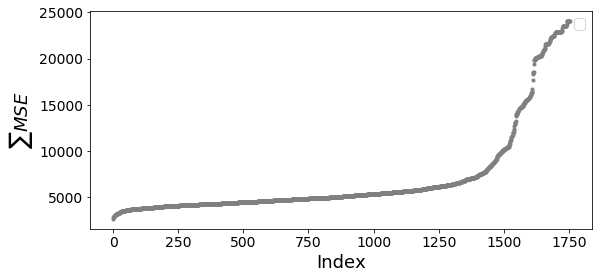

In [10]:
plotting.plt_idx_vs_mse(M4_sorted_mses_EA, len(M4_sorted_mses_EA))

No handles with labels found to put in legend.


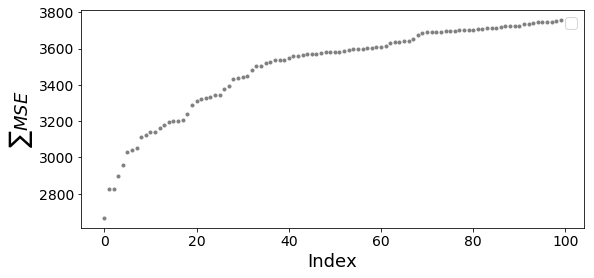

In [11]:
plotting.plt_idx_vs_mse(M4_sorted_mses_EA, 100)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

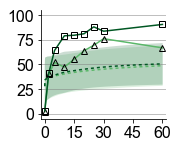

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

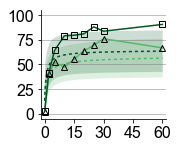

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

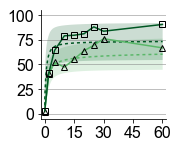

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

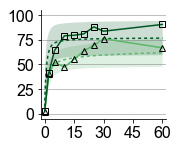

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

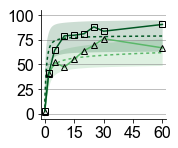

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

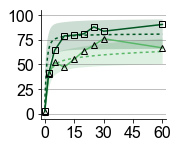

In [13]:
for num in [0, 10, 50, 100, 200, 500]:
    mses_EA, thetas_EA = model_supp.sort_mses_thetas(all_mses[:,num], all_params[:,num])
    plotting.plt_param_cis(model_fxns, thetas_EA, params_constants, initials,  [150000,550000], time, 2,
                            exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                            save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m4/t100a/'+str(num), save_as='.jpeg')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

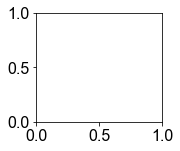

In [14]:
for num in [0, 10, 50, 100, 200, 500]:
    mses_EA, thetas_EA = model_supp.sort_mses_thetas(all_mses[:,num], all_params[:,num])
    plotting.plt_param_cis(model_fxns, thetas_EA, params_constants, initials,  [150000,550000], time, 2,
                            exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                            save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m4/wt/'+str(num), save_as='.jpeg')

In [15]:
e4_thetas = np.array(pd.read_csv('M4_kb_thetas_e4.csv').drop(['Unnamed: 0'], axis=1))

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


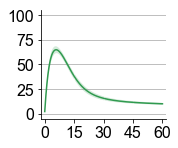

In [23]:
sims_nopos = plotting.nopos_to_list(model_fxns, e4_thetas, params_constants, initials, time, 2, ss = True)
# plotting.plt_ramp_cis(sims, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd',save_fig='')
for num in [600]:
    plotting.plt_nopos_cis(sims_nopos, time, num,hog1_data=None, mapk_time=mapk_ramp_time, ci='sd',save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m4/m4_nopos'+str(num))

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


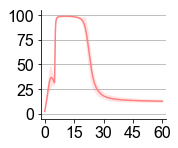

In [17]:
# sims0 = plotting.simdata_to_list(model_fxns, e4_thetas, params_constants, initials, time, 2, ss = True)
# plotting.plt_ramp_cis(sims, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd',save_fig='')
for num in [600]:
    plotting.plt_ramp_cis(sims0, time, num, 0, hog1_ramp_data=None, mapk_ramp_time=mapk_ramp_time, ci='sd',save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m4/ramp0_m4'+str(num))

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


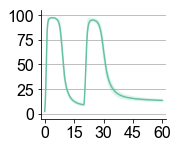

In [20]:
# sims1 = plotting.simdata_to_list(model_fxns, e4_thetas, params_constants, initials, time, 2, ss = True)
# plotting.plt_ramp_cis(sims, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd',save_fig='')
for num in [600]:
    plotting.plt_ramp_cis(sims1, time, num, 1, hog1_ramp_data=None, mapk_ramp_time=mapk_ramp_time, ci='sd',save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m4/ramp1_m4'+str(num))

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


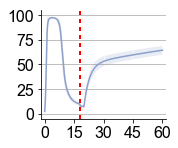

In [22]:
sims2 = plotting.inhibdata_to_list(model_fxns, e4_thetas, params_constants, initials, time, 2, 0, run_type=['ramp'], ss = True)
# plotting.plt_ramp_cis(sims, time, hog1_ramp_data=hog1_ramp_inhib_data, mapk_ramp_time=mapk_ramp_time, ci='sd')
# plotting.plt_ramp_cis(sims, time, hog1_ramp_data=None, mapk_ramp_time=mapk_ramp_time, ci='sd',save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m2c/ramp2_m2c')
# for num in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]:
for num in [ 600]:

    plotting.plt_ramp_cis(sims2, time, num, 2, hog1_ramp_data=None, mapk_ramp_time=mapk_ramp_time, ci='sd',save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m4/ramp2_m4'+str(num))

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

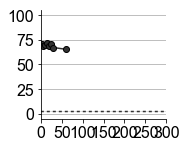

In [24]:
plotting.plt_param_cis_m2c_ptp(model_fxns, sorted_thetas_EA, params_constants, initials, [0], time, 2,
                        exp_data=mapk_ptpD_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=True, ci='sd',
                        save_fig='M2d_0_ptpD_0')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

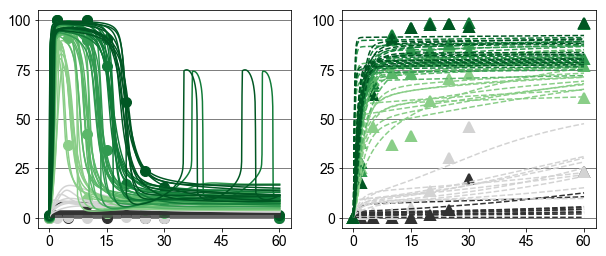

In [12]:
# original parameter values
plotting.plt_param_behaviors(M4_fxns, M4_sorted_thetas_EA, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

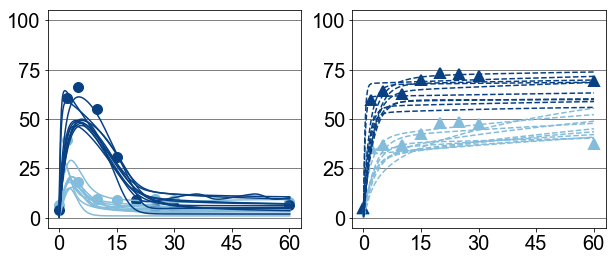

In [13]:
plotting.plt_param_behaviors(M4_fxns, M4_sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

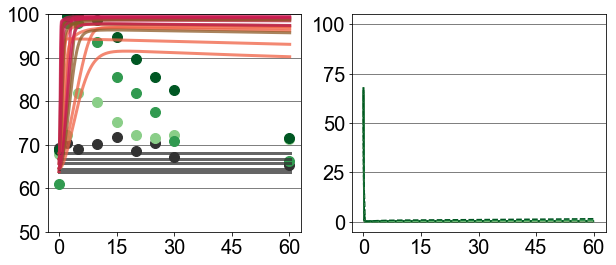

In [14]:
plotting.plt_param_behaviors(M4_fxns, M4_sorted_thetas_EA, 5, params_constants, initials, [0, 150000, 350000, 550000], time, 2, mapk_ptpD_data, None, mapk_time, ptp23D=True, save_fig='') # [0]+map2k_doses

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

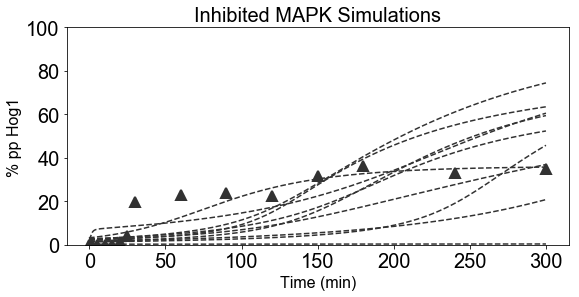

In [15]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M4_fxns, M4_sorted_thetas_EA, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


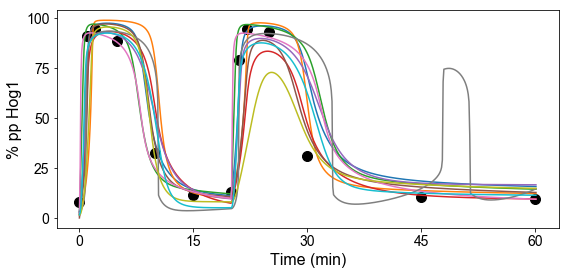

In [16]:
plotting.plt_ramp_behaviors(M4_fxns, M4_sorted_thetas_EA, 10, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

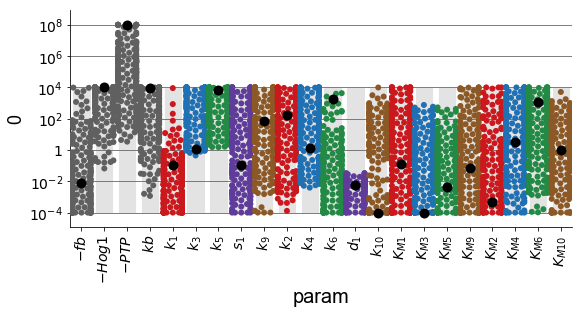

In [17]:
df_top_thetas_EA = pd.DataFrame(M4_sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(M4_sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

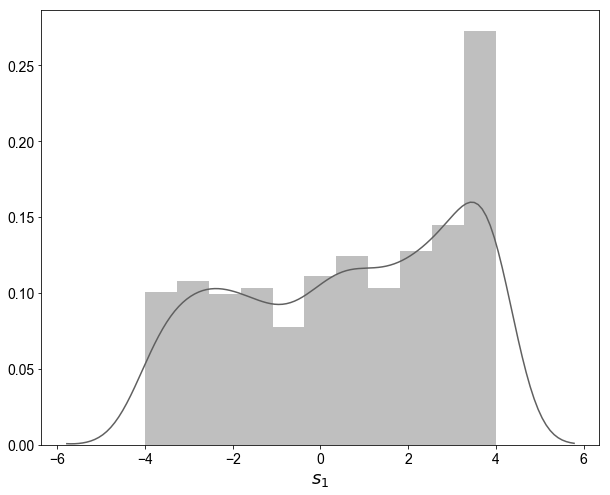

In [18]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[7]]))

In [19]:
sims_M4_kb_ea_l = plotting.simdata_to_list(M4_fxns, M4_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


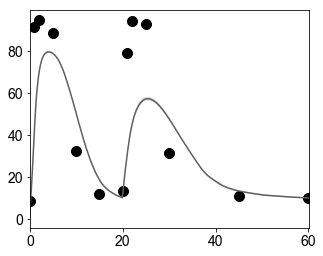

In [46]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


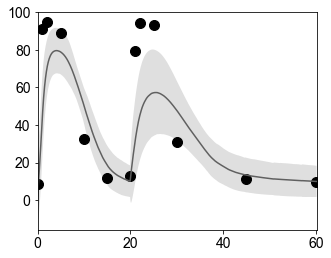

In [47]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

# SMC

## Try different sizes of EA 

I've been using top 500 and it's worked really well, but here I'm using top 20 so that it runs fast

In [59]:
M4_new_mses_EA, M4_new_thetas_EA = recalc_mses(M4_fxns, M4_sorted_thetas_EA, exp_data, exp_time, params_constants, initials, ptpD=True)

print(M4_new_mses_EA[:10])

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

[2658.70933463 2824.97428118 2860.27164091 2967.74403823 2977.5501253
 2977.87152964 2983.82346209 2989.96370376 2997.21424104 3037.49737219]


No handles with labels found to put in legend.


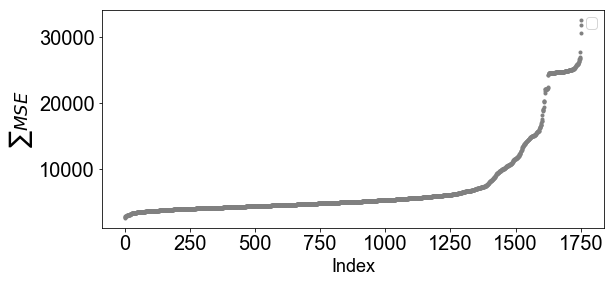

In [60]:
plotting.plt_idx_vs_mse(M4_new_mses_EA, len(M4_new_mses_EA))

In [61]:
M4_EA_thetas_1perc = M4_new_thetas_EA[:500]
M4_EA_mses_1perc = M4_new_mses_EA[:500]

## Define schedules

I've been messing around with where I start with the schedule and how many schedules to run

In [63]:
e1, e2, e3, e4 = def_schedules(M4_EA_mses_1perc)

print("Best MSE: " + str(M4_EA_mses_1perc[0]))
print("Worst MSE: " + str(M4_EA_mses_1perc[-1]))
print()
print("Schedules: " + str(e1),str(e2),str(e3),str(e4))
print()


Best MSE: 2658.709334626631
Worst MSE: 4435.624866385253

Schedules: 4435.624866385253 3547.167100505942 3102.9382175662868 2880.823776096459



## Define probability

I've also been messing around with the `top` and `bot` params of `scaled_prob_mses`. 
- (.9 and .1) 
- (.95 and .05) 
- (.99 and .01)

I've noticed that with the larger number of EA thetas, the more extreme ranges are better. 
If you start with a small number of EA thetas, being more conservative with the ranges
results in more balanced probabilities.

In [64]:
probs = scaled_prob_mses(M4_EA_mses_1perc, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])


[0.1151729274441141, 0.01132499138281336, 0.00950545094244768, 0.006382962494604468, 0.006197214782901876]
[0.0011674890130305515, 0.00116652202599618, 0.0011651282626039586, 0.001164602474175689, 0.0011633629034758998]


## Schedule 1

I use `num_theta_primes = 1000`, but set to 100 to be faster.

In [65]:
mses_e1, thetas_e1, count_e1 = run_schedule(M4_EA_thetas_1perc, probs, e1, num_theta_primes=1000)
mses_e1_sort, thetas_e1_sort = sort_mses_thetas(mses_e1, thetas_e1)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

10% complete.
20% complete.
30% complete.


../../python_modules\model.py:488: RuntimeWarning: divide by zero encountered in double_scalars
  
../../python_modules\model.py:488: RuntimeWarning: invalid value encountered in double_scalars
  
../../python_modules\model.py:489: RuntimeWarning: invalid value encountered in double_scalars
  dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
../../python_modules\model.py:490: RuntimeWarning: invalid value encountered in double_scalars
  dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
../../python_modules\model.py:491: RuntimeWarning: invalid value encountered in double_scalars
  dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6*PTP)*MAPK)/(K_6+MAPK)
../../python_modules\model.py:492: RuntimeWarning: invalid value encountered in double_scalars
  dgly = s7*MAPK - d8*gly
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to

40% complete.
50% complete.
60% complete.
70% complete.


../../python_modules\model.py:490: RuntimeWarning: overflow encountered in double_scalars
  dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))


80% complete.
90% complete.
100% complete.


In [116]:
df_top_thetas_e1 = pd.DataFrame(thetas_e1_sort)
df_top_thetas_e1.columns = labelnames

df_top_thetas_e1.to_csv('M4_kb_thetas_e1.csv')

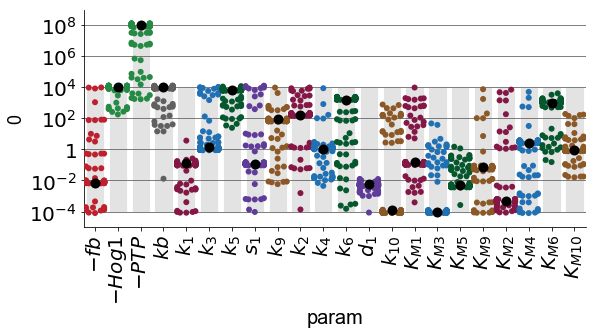

In [67]:
num_plt = 100
df_plt = pd.DataFrame(thetas_e1_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

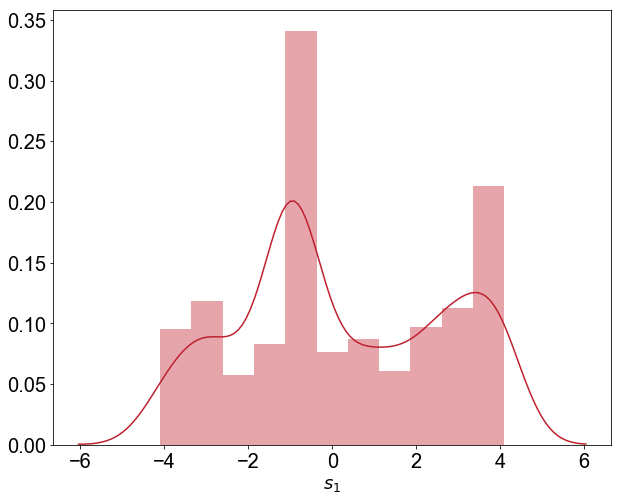

In [68]:
sns.distplot(np.log10(df_top_thetas_e1[labelnames[7]]))

<Figure size 720x576 with 0 Axes>

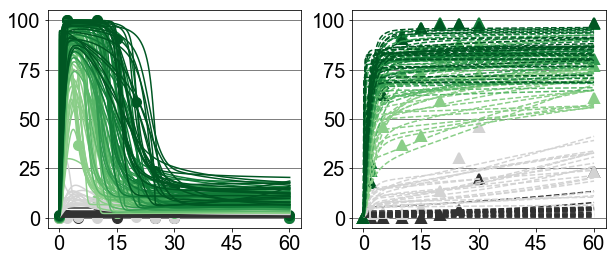

In [69]:
plotting.plt_param_behaviors(M4_fxns, thetas_e1, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

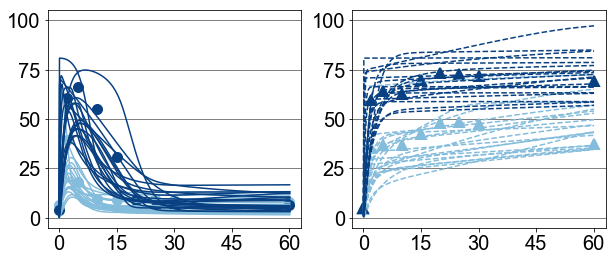

In [70]:
plotting.plt_param_behaviors(M4_fxns, thetas_e1, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [ ]:
sims_M2b_kb_e1 = plotting.simdata_to_list(M2b_fxns, thetas_e1_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.


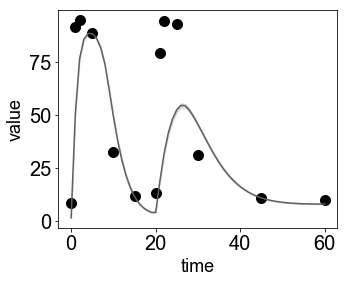

In [83]:
plotting.plt_ramp_cis(sims_M2b_kb_e1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

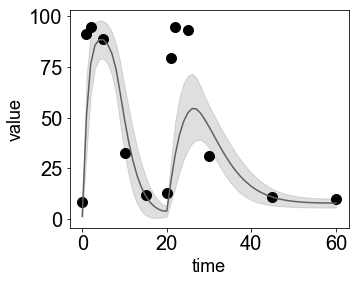

In [81]:
plotting.plt_ramp_cis(sims_M2b_kb_e1, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Schedule 2

Redefine probs based on results of last schedule.

In [71]:
probs = scaled_prob_mses(mses_e1_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.054988520878216034, 0.01964164667198646, 0.011821747572862527, 0.009934277472461176, 0.009767026249338558]
[0.0005564404960340691, 0.000556306774930308, 0.0005561071759743545, 0.0005560078656622289, 0.000555439604830465]


In [72]:
mses_e2, thetas_e2, count_e2 = run_schedule(thetas_e1_sort, probs, e2, num_theta_primes=1000)
mses_e2_sort, thetas_e2_sort = sort_mses_thetas(mses_e2, thetas_e2)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimiz

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [117]:
df_top_thetas_e2 = pd.DataFrame(thetas_e2_sort)
df_top_thetas_e2.columns = labelnames

df_top_thetas_e2.to_csv('M4_kb_thetas_e2.csv')

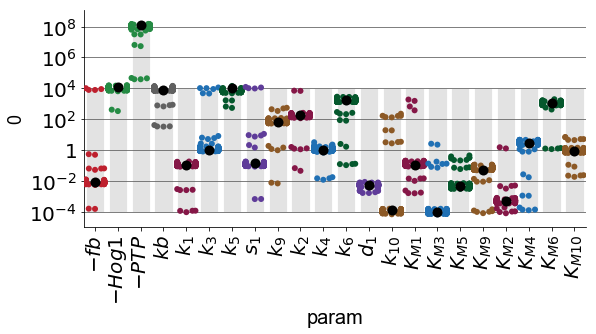

In [74]:
num_plt = 200
df_plt = pd.DataFrame(thetas_e2_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

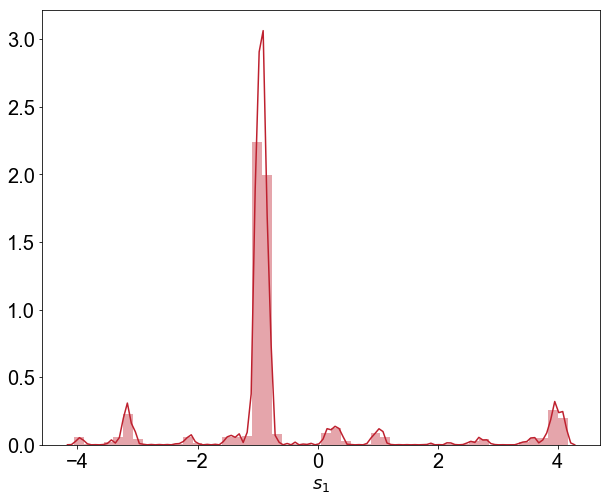

In [80]:
sns.distplot(np.log10(df_top_thetas_e2[labelnames[7]]))

<Figure size 720x576 with 0 Axes>

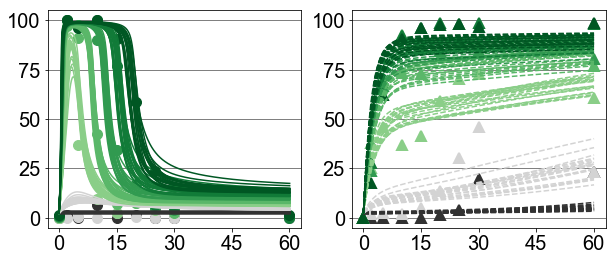

In [82]:
plotting.plt_param_behaviors(M4_fxns, thetas_e2_sort, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

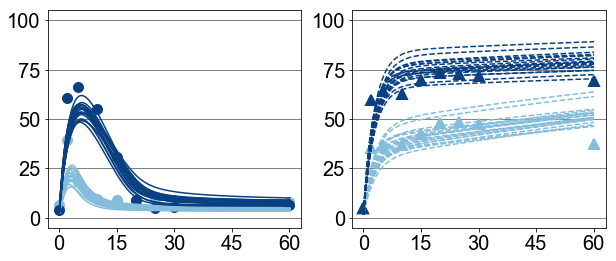

In [83]:
plotting.plt_param_behaviors(M4_fxns, thetas_e2_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [86]:
sims_M2b_kb_e2 = plotting.simdata_to_list(M4_fxns, thetas_e2_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


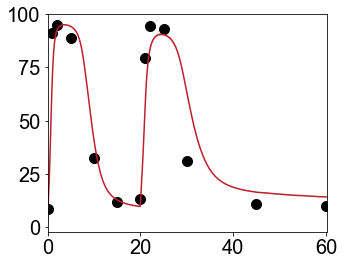

In [89]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


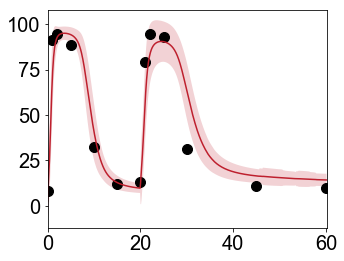

In [90]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Turning on and off inhib

In [103]:
M4_inhib_sims = plotting.inhibdata_to_list(M4_fxns, thetas_e2_sort, params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


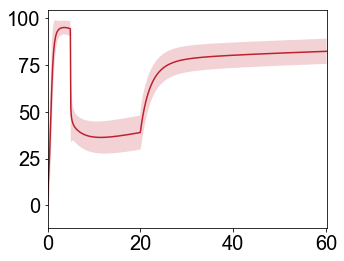

In [104]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


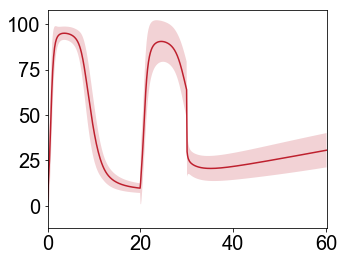

In [102]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>30 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


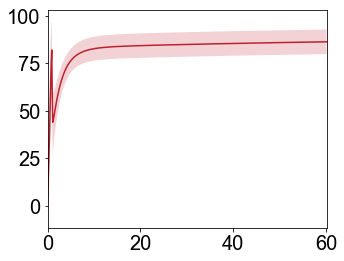

In [100]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>1

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


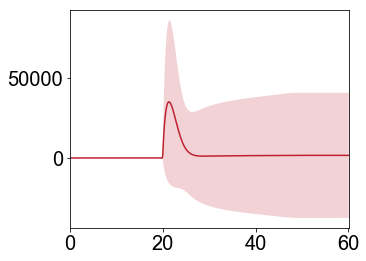

In [98]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t<20

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


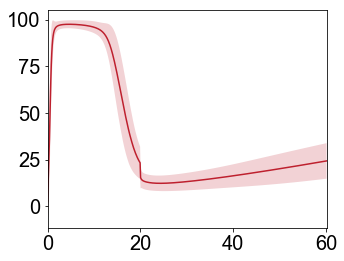

In [96]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>20

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


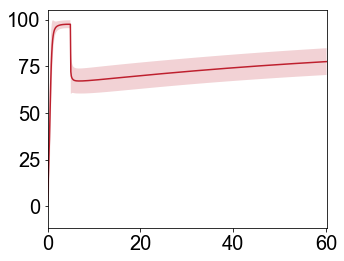

In [94]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5

### Investigating modality

PCA to see if modality can be explained by theta variance. Also, see if better scores are clustering together.

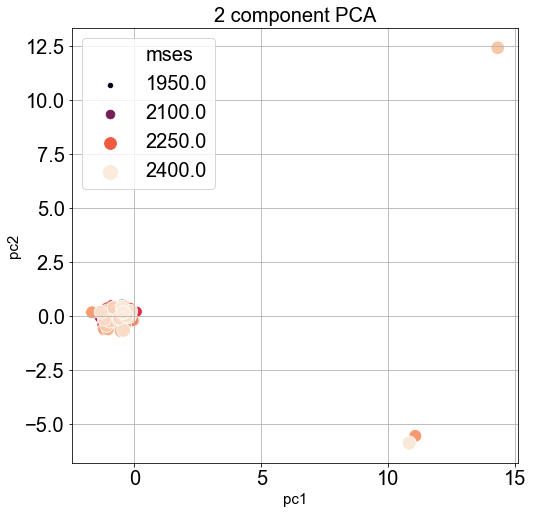

In [310]:
from sklearn.preprocessing import StandardScaler

df_top_thetas_e2_log = df_top_thetas_e2.apply(np.log10)

df_top_thetas_e2_log['mses'] = mses_e2_sort

x = df_top_thetas_e2_log.loc[:, labelnames].values
y = df_top_thetas_e2_log.loc[:,['mses']].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf, df_top_thetas_e2_log[['mses']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

sns.scatterplot(x='pc1', y='pc2', hue='mses', size='mses',sizes=(20, 200), data=finalDf[finalDf['mses']<2400], palette="rocket")

ax.grid()

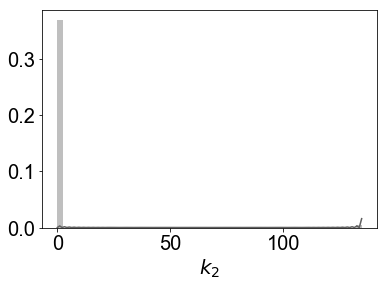

In [311]:
df_top_params_e2 = pd.DataFrame(thetas_e2)
df_top_params_e2.columns = labelnames
sns.distplot(df_top_params_e2[labelnames[7]])

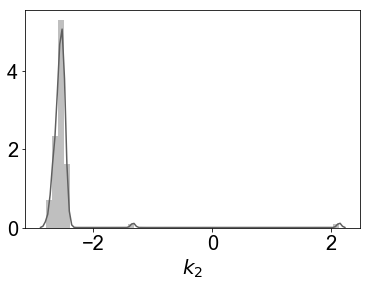

In [312]:
sns.distplot(np.log10(df_top_params_e2[labelnames[7]]))

<Figure size 432x288 with 0 Axes>

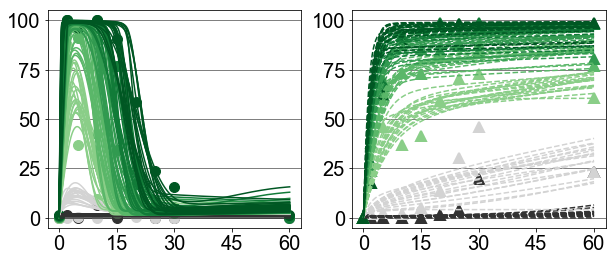

In [314]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 432x288 with 0 Axes>

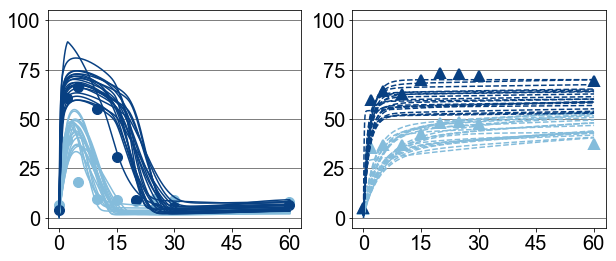

In [315]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

## Schedule 3 

In [105]:
probs = scaled_prob_mses(mses_e2_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.05685539915053727, 0.028139364279075436, 0.020767444762364577, 0.009703722565032368, 0.005561585516271893]
[0.0005753695411957641, 0.0005751391319863099, 0.0005749650423221875, 0.0005748509358101401, 0.0005742969611165381]


In [106]:
mses_e3, thetas_e3, count_e3 = run_schedule(thetas_e2_sort, probs, e3, num_theta_primes=1000)
mses_e3_sort, thetas_e3_sort = sort_mses_thetas(mses_e3, thetas_e3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [118]:
df_top_thetas_e3 = pd.DataFrame(thetas_e3_sort)
df_top_thetas_e3.columns = labelnames

df_top_thetas_e3.to_csv('M4_kb_thetas_e3.csv')

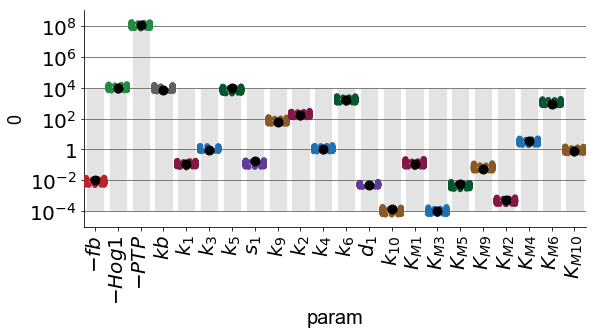

In [108]:
num_plt = 250
df_plt = pd.DataFrame(thetas_e3_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

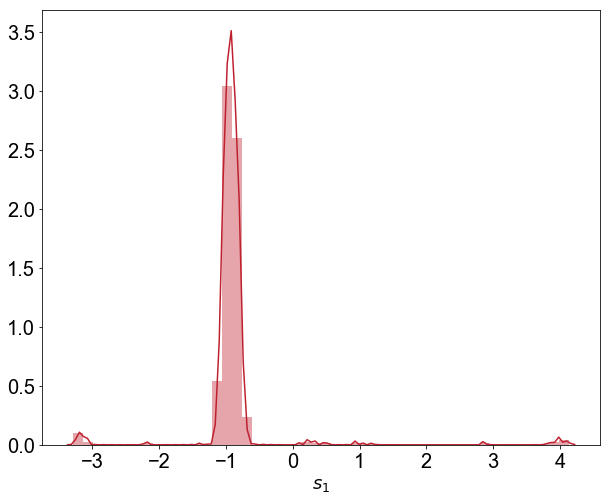

In [109]:
sns.distplot(np.log10(df_top_thetas_e3[labelnames[7]]))

<Figure size 720x576 with 0 Axes>

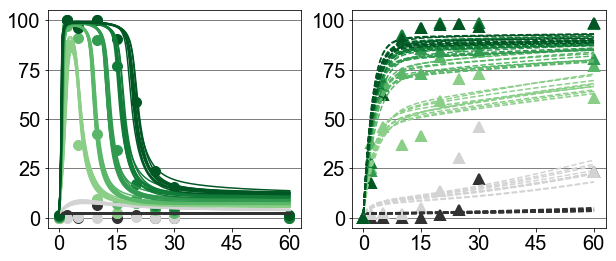

In [110]:
plotting.plt_param_behaviors(M4_fxns, thetas_e3_sort, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

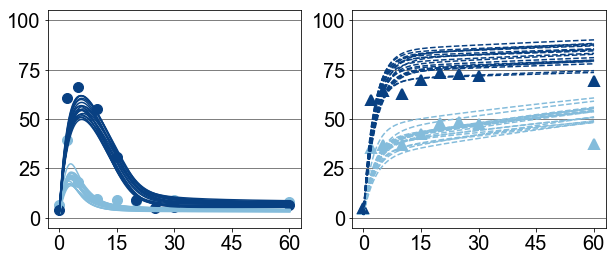

In [111]:
plotting.plt_param_behaviors(M4_fxns, thetas_e3_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [112]:
sims_M2b_kb_e3 = plotting.simdata_to_list(M4_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


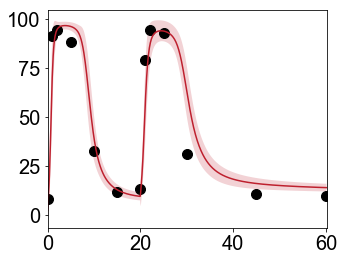

In [115]:
plotting.plt_ramp_cis(sims_M2b_kb_e3, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd', save_fig='')

## Schedule 4

In [141]:
probs = scaled_prob_mses(mses_e3_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.051581139193633295, 0.02624409336037292, 0.01055223063730911, 0.01026465728020007, 0.009431264438801192]
[0.0005213056855445805, 0.000521193680478518, 0.0005211457078339943, 0.0005210594173096417, 0.0005210216080164979]


In [142]:
mses_e4, thetas_e4, count_e4_M2b_kb = run_schedule(thetas_e3_sort, probs, e4, num_theta_primes=1000)
mses_e4_sort, thetas_e4_sort = sort_mses_thetas(mses_e4, thetas_e4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [143]:
df_top_thetas_e4 = pd.DataFrame(thetas_e4_sort)
df_top_thetas_e4.columns = labelnames
df_top_thetas_e4.to_csv('M4_kb_thetas_e4.csv')

In [ ]:
num_plt = 250
df_plt = pd.DataFrame(df_top_thetas_e4[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M4', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

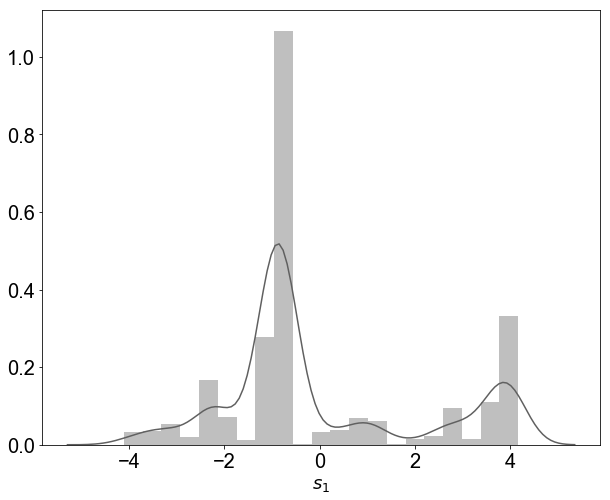

In [51]:
sns.distplot(np.log10(df_top_thetas_e4[labelnames[7]]))

In [8]:
e4_thetas = np.array(pd.read_csv('M4_kb_thetas_e4.csv').drop(['Unnamed: 0'], axis=1))

<Figure size 720x576 with 0 Axes>

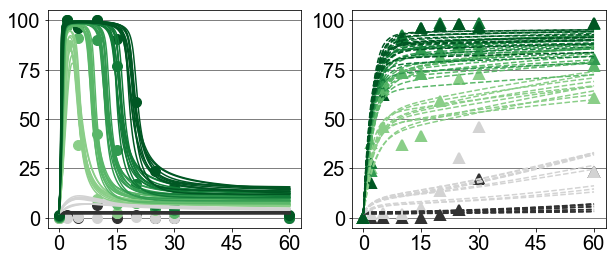

In [54]:
plotting.plt_param_behaviors(M4_fxns, thetas_e4_sort, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

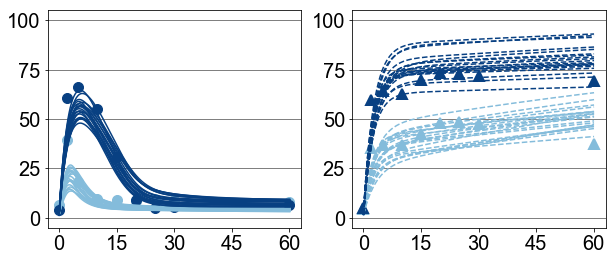

In [55]:
plotting.plt_param_behaviors(M4_fxns, thetas_e4_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [145]:
sims_M4_kb_e4 = plotting.simdata_to_list(M4_fxns, thetas_e4_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


In [ ]:
plotting.plt_ramp_cis(sims_M4_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

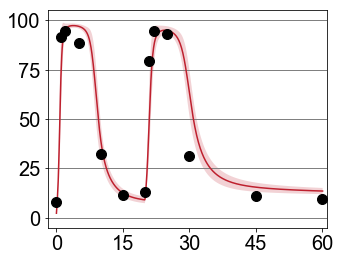

In [149]:

plotting.plt_ramp_cis(sims_M4_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd', save_fig='M3d_ramp.pdf')
mean =np.mean(np.array(sims_M4_kb_e4), axis=0)
std = np.std(np.array(sims_M4_kb_e4), axis=0)
# print(len(test))
# std = [2*x for i,x in enumerate(std) if i%10==0]
# plt.errorbar([x for i,x in enumerate(time) if i%10==0], [x for i,x in enumerate(mean) if i%10==0], yerr=std, fmt='-o')

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


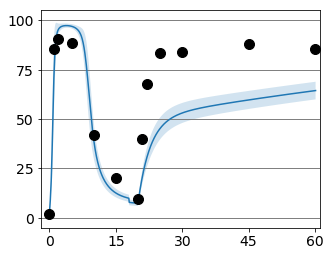

In [17]:
sims = plotting.inhibdata_to_list(M4_fxns, e4_thetas, params_constants, initials, time, 2, 0, run_type=['ramp'], ss = True)
plotting.plt_ramp_cis(sims, time, hog1_ramp_data=hog1_ramp_inhib_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


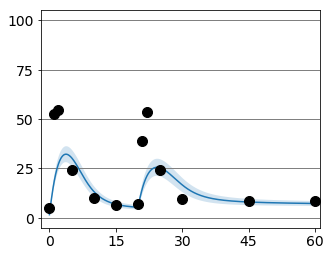

In [18]:
sims = plotting.simdata_to_list(M4_fxns, e4_thetas, params_constants, initials, time, 1, ss = True)
plotting.plt_ramp_cis(sims, time, hog1_ramp_data=pbs2_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

In [9]:
thetas_e4_sort = np.array(pd.read_csv("M4_kb_thetas_e4.csv").drop(['Unnamed: 0'], axis=1))

In [114]:
M4_inhib_sims = plotting.inhibdata_to_list(M4_fxns, thetas_e4_sort[:10], params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)



0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


In [49]:
# M4_inhib_sims = plotting.inhibdata_to_list(M4_fxns, thetas_e4_sort[:10], params_constants, initials, time, 3, sig=450000, run_type=['ramp'], ss = True)



C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


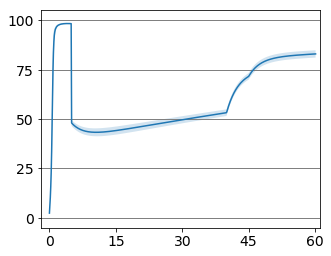

In [103]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


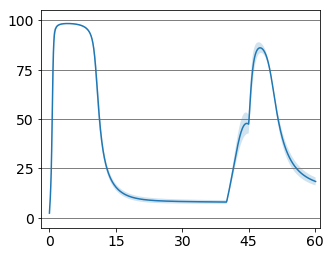

In [105]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5 with ramp

In [133]:
M4_inhib_sims = plotting.inhibdata_to_list(M4_fxns, thetas_e4_sort[:10], params_constants, initials, time, 3, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


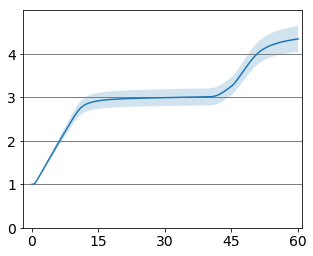

In [129]:
plotting.plt_inhib_cis(M4_inhib_sims, time, 3, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


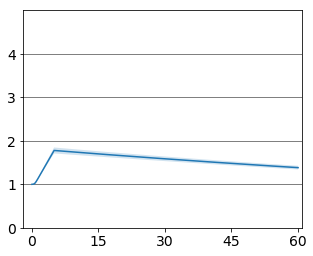

In [134]:
plotting.plt_inhib_cis(M4_inhib_sims, time, 3, ci="sd") #t>5 with ramp

Increasing step stimulus + inhibition. Inhibiting kinase activity even when downstream species is high. Observed reduced activation than if had been inhibited prior to stimulation.

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


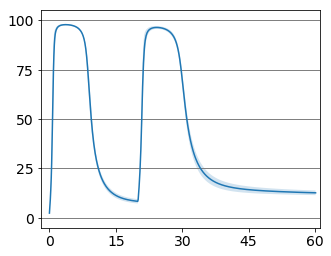

In [107]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


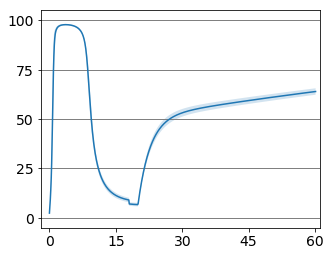

In [113]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


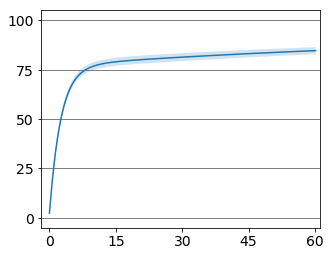

In [115]:
plotting.plt_inhib_cis(M4_inhib_sims, time, ci="sd") #t>5 with ramp

Downstream species behavior

In [126]:
M4_inhib_sims = plotting.inhibdata_to_list(M4_fxns, thetas_e4_sort[:10], params_constants, initials, time, 3, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


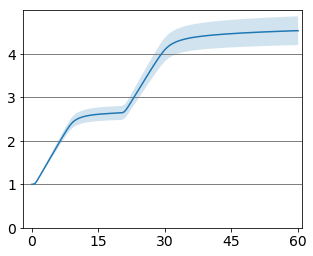

In [125]:
plotting.plt_inhib_cis(M4_inhib_sims, time, 3, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


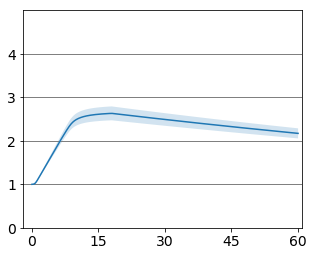

In [127]:
plotting.plt_inhib_cis(M4_inhib_sims, time, 3, ci="sd") #t>5 with ramp

Predition to on / off pulse. Doesn't align with data.

In [148]:
M4_inhib_sims = plotting.inhibdata_to_list(M4_fxns, thetas_e4_sort[:10], params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)



0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


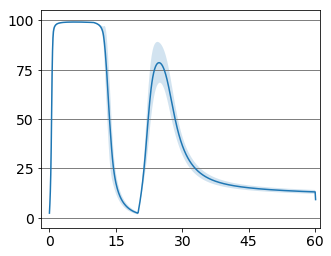

In [149]:
plotting.plt_inhib_cis(M4_inhib_sims, time, 2, ci="sd") #t>5 with ramp

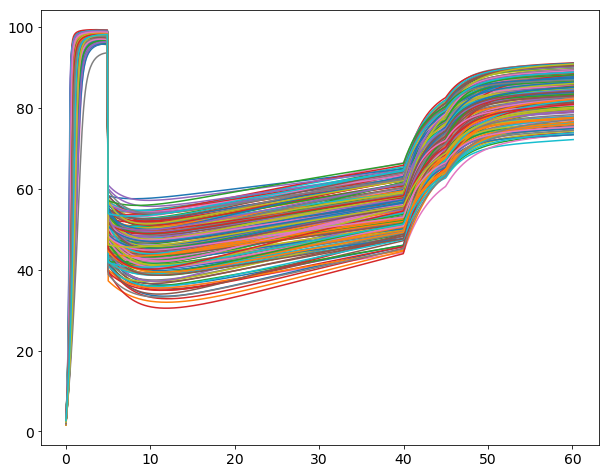

In [35]:
top = 800
bot = 1000
for sim in M4_inhib_sims[top:bot]:
    plt.plot(time, sim)

In [ ]:
plotting.plt_param_cis(model_fxns, thetas_EA, params_constants, initials,  [150000,550000], time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='C:/Users/sksuzuki/Documents/Research/figures/winter_qbio_talk/gif_m4/t100a/'+str(num), save_as='.jpeg')